# Set Parameter
- Attention = True
- Teacher Forcing Ratio = 0.5
- Dropout = 0.2
- Layer = 4
- Batch size = 128
- Learning rate = 0.001
- Hidden unit = 300
- Epochs = 20
- Data = ids

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging
import sys
import json
import numpy as np

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.chdir(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))))))

from models.trainer import Trainer
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from dataset import fields

import matplotlib.pyplot as plt

# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

In [3]:
character_accuracy = []
sentence_accuracy = []
f1_score = []
best_f1_score = []
rnn = "lstm"
data_name = "typo"
pretrained_dir_name = None
iterator = list(range(1,6,1))
epochs = 20

train_path = "data/network_inputs/iitk-"+data_name+"-1189"+"/data_train.txt"
dev_path = "data/network_inputs/iitk-"+data_name+"-1189"+"/data_val.txt"

config_path = "models/config.json"

# Prepare dataset

In [ ]:
for i in iterator:
        print("rnn : %s" % rnn)
        max_len = 450
        src = fields.SourceField()
        srcp = fields.SourceField()
        tgt = fields.TargetField()
        tgtp = fields.TargetField()
        def len_filter(example):
            return len(example.src) <= max_len and len(example.tgt) <= max_len
        train = torchtext.data.TabularDataset(
            path=train_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        dev = torchtext.data.TabularDataset(
            path=dev_path, format='tsv',
            fields=[('src', src), ('tgt', tgt)],
            filter_pred=len_filter
        )
        src.build_vocab(train)
        tgt.build_vocab(train)
        input_vocab = src.vocab
        output_vocab = tgt.vocab

        print("src vocab size = %d" % (len(src.vocab)))
        print("tat vacab size = %d" % (len(tgt.vocab)))

        weight = torch.ones(len(tgt.vocab))
        pad = tgt.vocab.stoi[tgt.pad_token]
        loss = Perplexity(weight, pad)
        if torch.cuda.is_available():
            loss.cuda()

        optimizer = "Adam"
        seq2seq = None
        config_json = open(config_path).read()
        config = json.loads(config_json)
        config["max_len"] = 450
        config["hidden_size"] = 300
        config["rnn_cell"] = rnn
        config["n_layers"] = 4
        config["dropout_p"] = 0.2
        config["embedding_size"] = 50
        config["use_attention"] = True
        config["position_embedding"] = "length"
        config["use_memory"] = None
        #config["seed"]= 1189
        #config["pos_add"] = "cat"

        print(json.dumps(config, indent=4))

        save_path = (data_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + ("_pretrained" if pretrained_dir_name is not None else ""))
        print("Save_path : %s" % save_path)
        
        if pretrained_dir_name is not None:
            pretrained_path = ("pretrained_weights/"+ data_name + "_" + pretrained_dir_name
                        + ("_att" if config["use_attention"] else "")
                        + ("_with_pos_" + config["position_embedding"] if config["position_embedding"] is not None else "")
                        + ("_cat" if config["pos_add"] == "cat" else "")
                        + ("_use_stack" if config["use_memory"] == "stack" else "")
                        + ("_use_queue" if config["use_memory"] == "queue" else "")
                        + "_emb" + str(config["embedding_size"])
                        + "_hidden" + str(config["hidden_size"])
                        + "_"+rnn+"_"+str(i))
            pretrained_pos_weight = np.load(pretrained_path+"/encoder_pos_weight.npy")
            seq2seq = Seq2seq(config, vocab_size, vocab_size, sos_id, eos_id,
                              pretrained_pos_weight)
        else :
            seq2seq = Seq2seq(config, len(src.vocab), len(tgt.vocab), tgt.sos_id, tgt.eos_id)
        
        if torch.cuda.is_available():
            seq2seq.cuda()

        for param in seq2seq.parameters():
            param.data.uniform_(-0.08, 0.08)

        # train
        t = Trainer(loss=loss, batch_size=128,
                    learning_rate=0.001,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=config["hidden_size"],
                    path=save_path,
                    file_name=config["rnn_cell"] + "_" + str(i))

        seq2seq, ave_loss, character_accuracy_list, sentence_accuracy_list, f1_score_list = t.train(seq2seq, train,
                                                                                 num_epochs=epochs, dev_data=dev,
                                                                                 optimizer=optimizer,
                                                                                 teacher_forcing_ratio=0.5)

        character_accuracy.append(character_accuracy_list)
        sentence_accuracy.append(sentence_accuracy_list)
        f1_score.append(f1_score_list)
        best_f1_score.append(max(f1_score_list))

rnn : lstm
src vocab size = 120
tat vacab size = 110


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
2020-05-27 16:34:13,510 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


{
    "encoder_max_len": 450,
    "decoder_max_len": 75,
    "embedding_size": 50,
    "hidden_size": 300,
    "input_dropout_p": 0,
    "dropout_p": 0.2,
    "n_layers": 4,
    "bidirectional": false,
    "rnn_cell": "lstm",
    "variable_lengths": true,
    "embedding": null,
    "update_embedding": true,
    "get_context_vector": false,
    "use_attention": true,
    "attn_layers": 1,
    "hard_attn": false,
    "encoder_position_embedding": null,
    "decoder_position_embedding": null,
    "pos_add": "add",
    "use_memory": null,
    "memory_dim": 5,
    "seed": null
}
Save_path : typo_att_emb50_hidden300


/home/hyeontae/hyeontae/venv1/lib/python3.6/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2020-05-27 16:41:11,411 INFO   Finished epoch 1: Train loss: 10.3254, Dev loss: 12.1790, Accuracy(character): 0.2833, Accuracy(sentence): 0.0043, F1 Score: 0.2791
2020-05-27 16:48:14,275 INFO   Finished epoch 2: Train loss: 8.2446, Dev loss: 12.5847, Accuracy(character): 0.2701, Accuracy(sentence): 0.0127, F1 Score: 0.2614
2020-05-27 16:55:15,639 INFO   Finished epoch 3: Train loss: 7.7977, Dev loss: 11.4824, Accuracy(character): 0.2886, Accuracy(sentence): 0.0045, F1 Score: 0.2835
2020-05-27 17:02:04,527 INFO   Finished epoch 4: Train loss: 7.7878, Dev loss: 11.2821, Accuracy(character): 0.2826, Accuracy(sentence): 0.0125, F1 Score: 0.2751
2020-05-27 17:08:57,459 INFO   Finished epoch 5: Train loss: 7.4037, Dev loss: 10.5070, Accuracy(character): 0.2989,

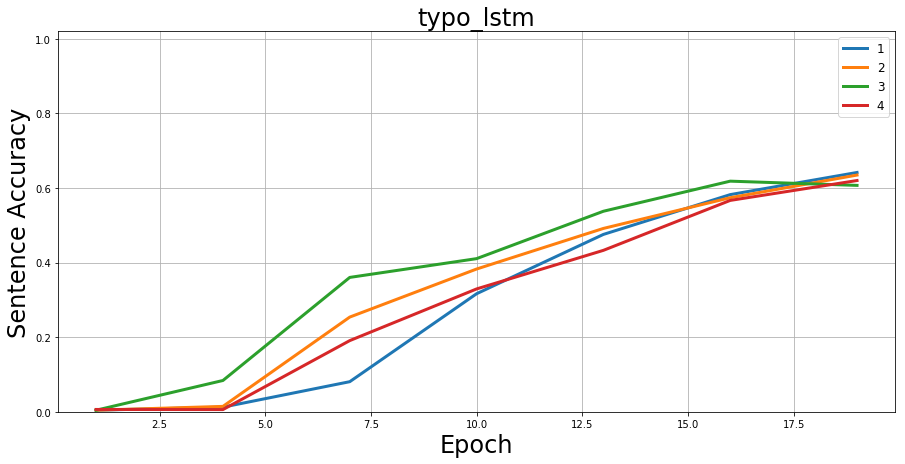

In [5]:
plt.figure(figsize=(15,7))
for j in range(len(sentence_accuracy)):
    plt.plot(list(range(1, len(sentence_accuracy[j])+1, 1))[::3], sentence_accuracy[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentence Accuracy', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

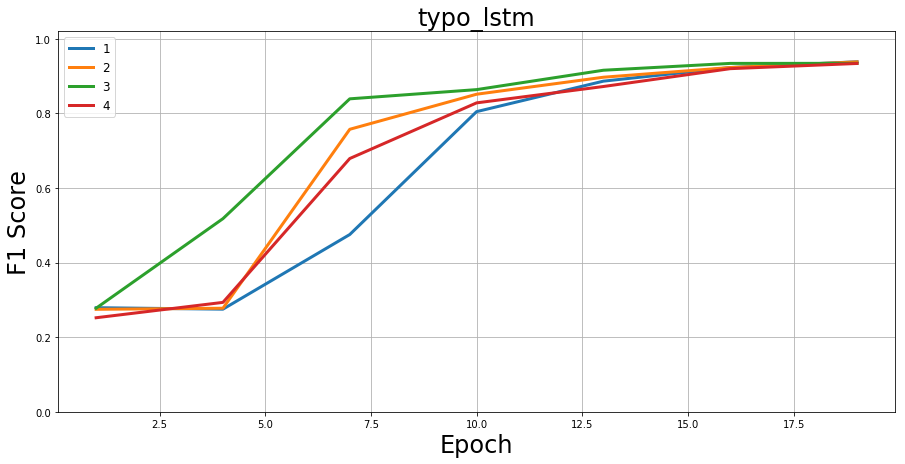

In [6]:
plt.figure(figsize=(15,7))
for j in range(len(f1_score)):
    plt.plot(list(range(1, len(f1_score[j])+1, 1))[::3], f1_score[j][::3], '-', LineWidth=3, label=str(j+1))

plt.legend(loc="best", fontsize=12)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

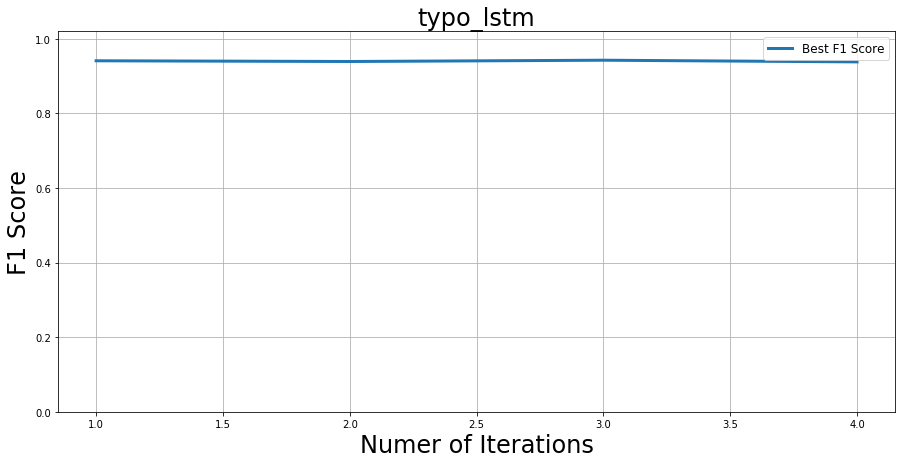

In [7]:
plt.figure(figsize=(15,7))
plt.plot(list(range(1, len(best_f1_score)+1)), best_f1_score, '-', LineWidth=3, label="Best F1 Score")

plt.legend(loc="best", fontsize=12)
plt.xlabel('Numer of Iterations', fontsize=24)
plt.title(data_name+"_"+rnn, fontsize=24)
plt.ylabel('F1 Score', fontsize=24)
plt.ylim([0, 1.02])
plt.grid()
#plt.savefig('')

In [8]:
print(f1_score)

[[0.2790647219272543, 0.26140884596366837, 0.2835001432483081, 0.27509466238457314, 0.29367126585230646, 0.28924621919620513, 0.4751706039197733, 0.6794450452964913, 0.7622663010087628, 0.8045958639964015, 0.8361748443952566, 0.8671458450272057, 0.8863193260546265, 0.9047587613471852, 0.915682505431523, 0.9227670233457507, 0.9296027262128956, 0.9310664016770576, 0.9382554297846252, 0.9409155264060942], [0.274730870027205, 0.19585386513005362, 0.2750228392167478, 0.27762227416634616, 0.38065111004104146, 0.6839766287721768, 0.7572690814459416, 0.7955939695930181, 0.8275613836225021, 0.8512732622337897, 0.8700538563617544, 0.8790810033479034, 0.8968451710524818, 0.9037065881490287, 0.9172030274163517, 0.9227926185313616, 0.9320502731544448, 0.9334022774280065, 0.9380052194176874, 0.9389905303309899], [0.27770714477248976, 0.26191198858571346, 0.29061483409238775, 0.5177388298958782, 0.7210432976312348, 0.8045880773128545, 0.8389112338757587, 0.8603298774204201, 0.8734248310762701, 0.8636

In [9]:
print(best_f1_score)

[0.9409155264060942, 0.9389905303309899, 0.9424492770403264, 0.9379756481762254]


In [10]:
print(sum(best_f1_score, 0.0)/len(best_f1_score))

0.940082745488409
